# Neural Network Training with DataJoint

In this session, we are going to look at how we can use DataJoint to train neural networks, exploring various **hyperparameters** for the training.

As always we are going to start with importing the essential scientific Python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
import time
from tqdm import tqdm

and we are also going to import the PyTorch package `torch` as well as the associated `torchvision` package that provides means of downloading and handling popular machine learning datasets.

In [2]:
import torch # import the PyTorch package
import torchvision # import trochvision package
from torchvision import transforms # get torchvision's transforms subpackage

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


As an example, we'll work with MNIST handwritten digit datasets.

In [3]:
# create a composite transform that first converts images to tensors and then normalize the images
image_transform = transforms.Compose([
    transforms.ToTensor(), # converts images into Tensors
    transforms.Normalize([0.1307], [0.3081])
])

# apply the transforms at the time of dataset loading
train_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)
test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                          transform=image_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



This returns Torchvision's special **dataset** object that can be used to represent **supervised datasets** consisting of both inputs (i.e. images) and targets (i.e. digit labels).

In [4]:
len(train_set)

60000

In [5]:
image, label = train_set[100]

Text(0.5, 1.0, 'Digit: 5')

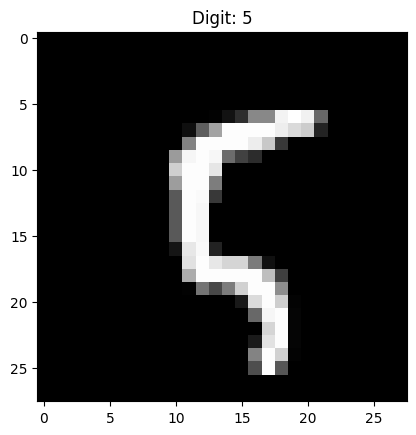

In [6]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Digit: {}'.format(label))

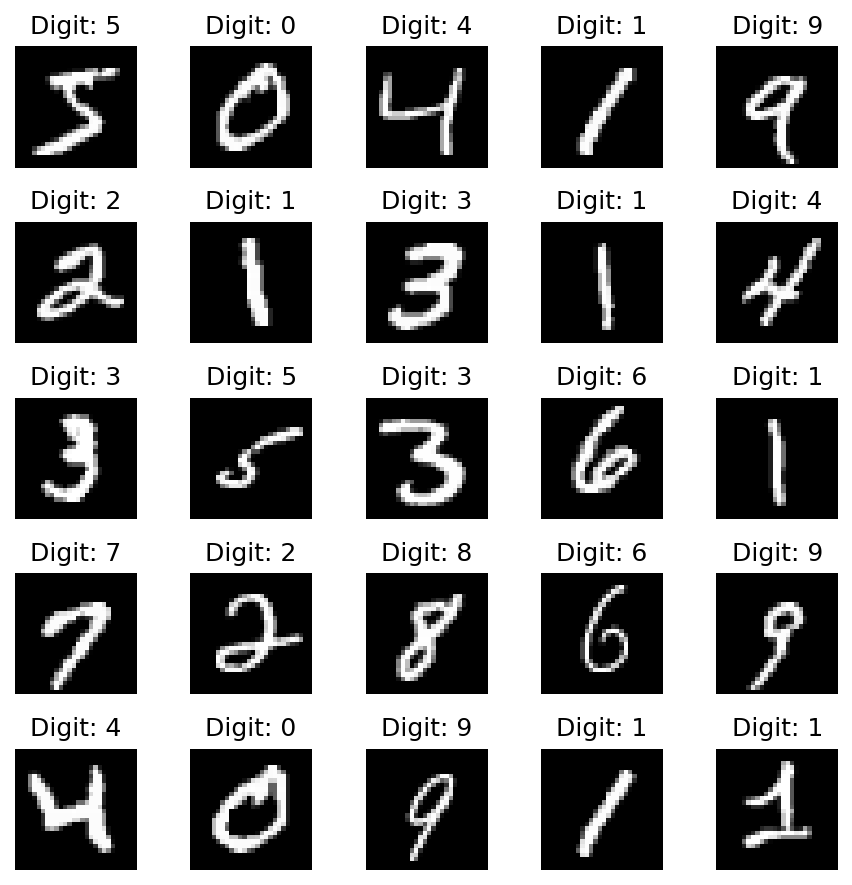

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6), dpi=150)

for i, ax in enumerate(axs.ravel()):
    image, label = train_set[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('Digit: {}'.format(label))
    ax.axis('off')
    
fig.tight_layout()

In [8]:
image, label = test_set[3]

Text(0.5, 1.0, 'Digit: 1')

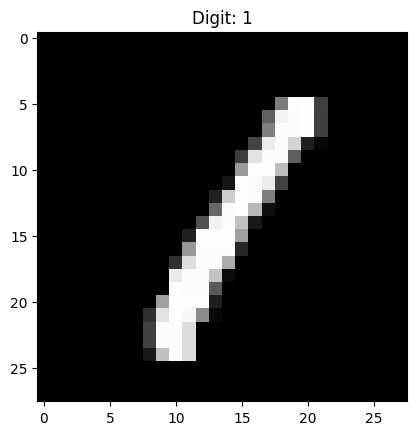

In [9]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Digit: {}'.format(label))

# Building a network for classification

In PyTorch, you define a new neural network by defining a **new class that inherits from nn.Module** as follows:

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Network(nn.Module):
    def __init__(self, hidden_size=50):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        x = x.view(-1, 784) # flattens an image of form N x 1 x 28 x 28 -> N x 784
        x = F.relu(self.fc1(x)) # first fully connected layer followed by ReLU
        x = self.fc2(x) # third fully connected layer *without* output ReLU
        x = F.log_softmax(x, dim=1) # make sure that probabilities add up to one, and then take log
        return x

This network was **one hyperparameter - the size of the hidden layer** (defaulting to 50 here)

In [12]:
batch_size = 64 # this is another hyperparameter!
training_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) # by default shuffle is False

## Training the network

In [13]:
net = Network()
net.train() # puts the network into the training mode

# create and initialize an optimizer
# learning rate is another hyperparameter!
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

start = time.time()
for epoch_idx in range(3): # number of epochs is yet another hyperparameter!
    for batch_idx, (data, target) in enumerate(training_loader):
        # reset the gradient before the next gradient step
        optimizer.zero_grad()

        # evaluate the network output
        output = net(data)

        # compute the loss
        loss = F.nll_loss(output, target)

        # perform back propagation to compute gradients with respect to parameters!
        loss.backward()

        # perform a gradient descent step on the parameters
        optimizer.step()

        # report the loss every 100 batches
        if batch_idx % 100 == 0:
            print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))
            
duration = time.time() - start
print('Training completed in {:.2f} seconds'.format(duration))

Epoch 0 Loss: 2.359733
Epoch 0 Loss: 1.484619
Epoch 0 Loss: 1.015266
Epoch 0 Loss: 0.837175
Epoch 0 Loss: 0.660247
Epoch 0 Loss: 0.679588
Epoch 0 Loss: 0.382023
Epoch 0 Loss: 0.498779
Epoch 0 Loss: 0.418124
Epoch 0 Loss: 0.401161
Epoch 1 Loss: 0.355251
Epoch 1 Loss: 0.309785
Epoch 1 Loss: 0.291532
Epoch 1 Loss: 0.272608
Epoch 1 Loss: 0.482465
Epoch 1 Loss: 0.336396
Epoch 1 Loss: 0.296591
Epoch 1 Loss: 0.253226
Epoch 1 Loss: 0.361455
Epoch 1 Loss: 0.405660
Epoch 2 Loss: 0.402536
Epoch 2 Loss: 0.433772
Epoch 2 Loss: 0.198952
Epoch 2 Loss: 0.339058
Epoch 2 Loss: 0.321019
Epoch 2 Loss: 0.209671
Epoch 2 Loss: 0.226171
Epoch 2 Loss: 0.292583
Epoch 2 Loss: 0.226867
Epoch 2 Loss: 0.311137
Training completed in 34.53 seconds


## Evaluating the network

In [14]:
net.eval() # put network into evaluation model
test_loss = 0
correct = 0

# prevents unnecessary gradient computation during test - can lead to time and memory saving
with torch.no_grad(): 
    for data, target in tqdm(test_loader):
        output = net(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target, reduction='sum').item() 
        
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1] 
        
        # count number of times where max probability matches the label index
        correct += pred.eq(target.view_as(pred)).sum().item()

# divide the test loss by number of samples in the test set
test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * accuracy))

100%|██████████| 938/938 [00:11<00:00, 84.27it/s]


Test set: Average loss: 0.2992, Accuracy: 54786/60000 (91%)



Let's look at actual guesses

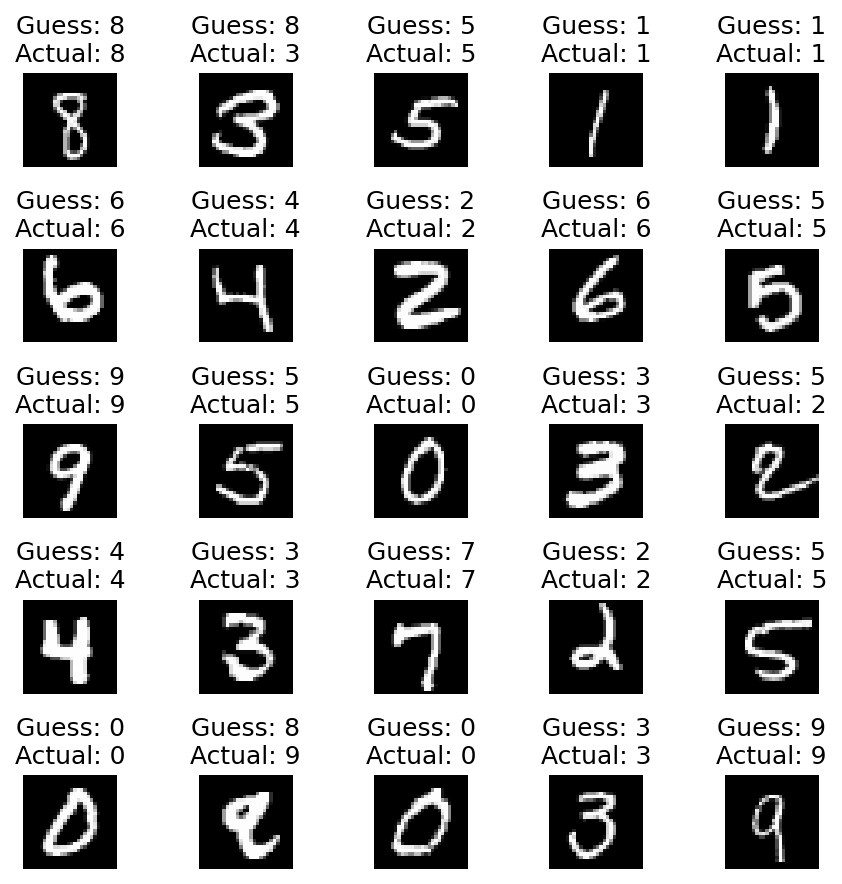

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6), dpi=150)
image_order = np.random.permutation(len(test_set))
for i, ax in zip(image_order, axs.ravel()):
    image, label = test_set[i]
    p = torch.exp(net(image))
    digit = torch.argmax(p)
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('Guess: {}\nActual: {}'.format(digit, label))
    ax.axis('off')
    
fig.tight_layout()

## Using DataJoint to coordinate the training

Now let's see how we can use DataJoint to streamline this process.

In [16]:
import datajoint as dj

In [17]:
# create a new schema to house tables for network training
schema = dj.schema('network')

[2022-08-17 20:32:11,835][INFO]: Connecting root@mysql:3306
[2022-08-17 20:32:11,844][INFO]: Connected root@mysql:3306


In [18]:
@schema
class NetworkConfig(dj.Lookup):
    definition = """
    hidden_size: int    # size of hidden layer
    """
    contents = zip([50])
    
@schema
class TrainingConfig(dj.Lookup):
    definition = """
    train_config_id: int   # unique id for a training config
    ---
    learning_rate: float   # learning rate for SGD
    batch_size: int        # batch_size for training
    n_epochs: int          # number of epochs to train
    """
    contents = [
        (0, 0.005, 64, 3)
    ]
    

@schema
class TrainedNetwork(dj.Computed):
    definition = """
    -> NetworkConfig
    -> TrainingConfig
    ---
    train_duration: float   # duration of training in seconds
    test_loss: float        # loss on the test set
    test_acc: float         # accuracy on the test set
    """
    
    def make(self, key):
        # Get configurations!
        hidden_size = (NetworkConfig & key).fetch1('hidden_size')
        learning_rate, batch_size, n_epochs = (TrainingConfig & key).fetch1('learning_rate',
                                                                            'batch_size',
                                                                            'n_epochs')
        # convert from numpy array into int
        batch_size, n_eochs = int(batch_size), int(n_epochs)
        
        # prepare the data
        image_transform = transforms.Compose([
            transforms.ToTensor(), # converts images into Tensors
            transforms.Normalize([0.1307], [0.3081])
        ])

        # apply the transforms at the time of dataset loading
        train_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                                  transform=image_transform)
        test_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                                  transform=image_transform)
        
        # prepare data loaders
        training_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size) # by default shuffle is False
        
        # instantiate the network
        net = Network(hidden_size=hidden_size)
        net.train() # puts the network into the training mode

        # configure optimizer
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

        start = time.time()
        for epoch_idx in range(n_epochs):
            for batch_idx, (data, target) in enumerate(training_loader):
                # reset the gradient before the next gradient step
                optimizer.zero_grad()

                # evaluate the network output
                output = net(data)

                # compute the loss
                loss = F.nll_loss(output, target)

                # perform back propagation to compute gradients with respect to parameters!
                loss.backward()

                # perform a gradient descent step on the parameters
                optimizer.step()

                # report the loss every 100 batches
                if batch_idx % 100 == 0:
                    print('Epoch {} Loss: {:.6f}'.format(epoch_idx, loss.item()))

        duration = time.time() - start
        print('Training completed in {:.2f} seconds'.format(duration))
        
        ## Evaluate the network
        net.eval() # put network into evaluation model
        test_loss = 0
        correct = 0

        # prevents unnecessary gradient computation during test - can lead to time and memory saving
        with torch.no_grad(): 
            for data, target in test_loader:
                output = net(data)

                # sum up batch loss
                test_loss += F.nll_loss(output, target, reduction='sum').item() 

                # get the index of the max log-probability
                pred = output.max(1, keepdim=True)[1] 

                # count number of times where max probability matches the label index
                correct += pred.eq(target.view_as(pred)).sum().item()

        # divide the test loss by number of samples in the test set
        test_loss /= len(test_loader.dataset)
        
        # compute accuracy
        accuracy = correct / len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * accuracy))
        
        key['train_duration'] = duration
        key['test_loss'] = test_loss
        key['test_acc'] = accuracy
        
        self.insert1(key)

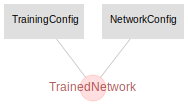

In [19]:
dj.Diagram(schema)

In [20]:
TrainingConfig()

train_config_id unique id for a training config,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
0,0.005,64,3


In [21]:
NetworkConfig()

hidden_size size of hidden layer
50


In [22]:
TrainedNetwork.populate()

Epoch 0 Loss: 2.401687
Epoch 0 Loss: 1.554016
Epoch 0 Loss: 1.117776
Epoch 0 Loss: 0.725663
Epoch 0 Loss: 0.708018
Epoch 0 Loss: 0.514487
Epoch 0 Loss: 0.703273
Epoch 0 Loss: 0.448390
Epoch 0 Loss: 0.416885
Epoch 0 Loss: 0.488052
Epoch 1 Loss: 0.414082
Epoch 1 Loss: 0.372046
Epoch 1 Loss: 0.342033
Epoch 1 Loss: 0.650801
Epoch 1 Loss: 0.477026
Epoch 1 Loss: 0.254260
Epoch 1 Loss: 0.264707
Epoch 1 Loss: 0.486194
Epoch 1 Loss: 0.411908
Epoch 1 Loss: 0.241437
Epoch 2 Loss: 0.249183
Epoch 2 Loss: 0.302817
Epoch 2 Loss: 0.385884
Epoch 2 Loss: 0.425442
Epoch 2 Loss: 0.259035
Epoch 2 Loss: 0.318710
Epoch 2 Loss: 0.466916
Epoch 2 Loss: 0.214962
Epoch 2 Loss: 0.260632
Epoch 2 Loss: 0.249120
Training completed in 34.89 seconds

Test set: Average loss: 0.3008, Accuracy: 54897/60000 (91%)



In [23]:
TrainedNetwork()

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set
50,0,34.8941,0.300849,0.91495


## Try more hyperparameter values

Now let's add a few more entries into the config tables and try out different combinations of hyperparameters for network training.

In [24]:
NetworkConfig().insert1((200, ))

In [25]:
NetworkConfig()

hidden_size size of hidden layer
50
200


In [26]:
TrainingConfig.insert1([1, 0.005, 64, 5])

In [27]:
TrainingConfig()

train_config_id unique id for a training config,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
0,0.005,64,3
1,0.005,64,5


In [28]:
TrainedNetwork.populate(display_progress=True)

TrainedNetwork:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Loss: 2.356392
Epoch 0 Loss: 1.503497
Epoch 0 Loss: 1.137181
Epoch 0 Loss: 0.787948
Epoch 0 Loss: 0.578855
Epoch 0 Loss: 0.522184
Epoch 0 Loss: 0.384749
Epoch 0 Loss: 0.506372
Epoch 0 Loss: 0.614739
Epoch 0 Loss: 0.355393
Epoch 1 Loss: 0.479378
Epoch 1 Loss: 0.407299
Epoch 1 Loss: 0.413924
Epoch 1 Loss: 0.448910
Epoch 1 Loss: 0.450451
Epoch 1 Loss: 0.266469
Epoch 1 Loss: 0.287065
Epoch 1 Loss: 0.414213
Epoch 1 Loss: 0.530107
Epoch 1 Loss: 0.159515
Epoch 2 Loss: 0.312425
Epoch 2 Loss: 0.315234
Epoch 2 Loss: 0.301359
Epoch 2 Loss: 0.270998
Epoch 2 Loss: 0.223863
Epoch 2 Loss: 0.285616
Epoch 2 Loss: 0.305594
Epoch 2 Loss: 0.580377
Epoch 2 Loss: 0.305043
Epoch 2 Loss: 0.162520
Training completed in 35.97 seconds


TrainedNetwork:  33%|███▎      | 1/3 [00:47<01:34, 47.41s/it]


Test set: Average loss: 0.2906, Accuracy: 54953/60000 (92%)

Epoch 0 Loss: 2.339569
Epoch 0 Loss: 1.332162
Epoch 0 Loss: 0.993663
Epoch 0 Loss: 0.758467
Epoch 0 Loss: 0.699886
Epoch 0 Loss: 0.480846
Epoch 0 Loss: 0.406586
Epoch 0 Loss: 0.342569
Epoch 0 Loss: 0.499244
Epoch 0 Loss: 0.397431
Epoch 1 Loss: 0.310082
Epoch 1 Loss: 0.438363
Epoch 1 Loss: 0.265766
Epoch 1 Loss: 0.393459
Epoch 1 Loss: 0.370261
Epoch 1 Loss: 0.363860
Epoch 1 Loss: 0.432326
Epoch 1 Loss: 0.333886


TrainedNetwork:  33%|███▎      | 1/3 [01:09<02:19, 69.91s/it]

KeyboardInterrupt



In [29]:
TrainedNetwork()

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set
50,0,34.8941,0.300849,0.91495
200,0,35.9681,0.29064,0.915883


In [30]:
TrainedNetwork * TrainingConfig

hidden_size size of hidden layer,train_config_id unique id for a training config,train_duration duration of training in seconds,test_loss loss on the test set,test_acc accuracy on the test set,learning_rate learning rate for SGD,batch_size batch_size for training,n_epochs number of epochs to train
50,0,34.8941,0.300849,0.91495,0.005,64,3
200,0,35.9681,0.29064,0.915883,0.005,64,3
